In [1]:
import pandas as pd
import numpy as np

In [2]:
# Load the cleaned dataset
df = pd.read_csv('cleaned.csv', parse_dates=['Time', 'DateTime'])

In [3]:
# Extract hour, day of the week, and whether it's a weekend
df['Hour'] = df['Time'].dt.hour
df['Minute'] = df['Time'].dt.minute
df['DayOfWeek'] = df['Time'].dt.dayofweek  # Monday=0, Sunday=6
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

In [4]:
features = [
    'RH [%]', 'Temperature [°C]',
    'WBT_C', 'Hour', 'Minute', 'DayOfWeek', 'IsWeekend'
]

In [5]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform the features
df[features] = scaler.fit_transform(df[features])

In [6]:
# Define the number of previous time steps to consider
sequence_length = 10  # Adjust as needed

# Create sequences
def create_sequences(data, target, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)

# Prepare the data
X_data = df[features].values
y_data = df['CH Load'].values  # Assuming 'CH Load' is the target variable

X, y = create_sequences(X_data, y_data, sequence_length)

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Example of a deeper model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1))


# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

/Users/sarthaktanwar/Coding/python-projects/r-menCodeCortex/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
# Determine the split index
train_size = int(0.8 * len(X))

# Split the data
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [9]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,  # You can adjust this
    batch_size=16,  # Adjust as needed
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 2457.3347 - val_loss: 1071.4840
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1690.0339 - val_loss: 760.2839
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1272.8073 - val_loss: 556.6392
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 953.8555 - val_loss: 434.6740
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 727.9247 - val_loss: 372.2462
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 590.0364 - val_loss: 351.7379
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 460.0089 - val_loss: 357.6574
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 435.2984 - val_loss: 377.8206
Epoch 9/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 392.9805 - val_loss: 402.5862
Epoch 10/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 373.7032 - val_loss: 427.0991
Epoch 11/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 371.8388 - val_loss: 446.3970
Epoc

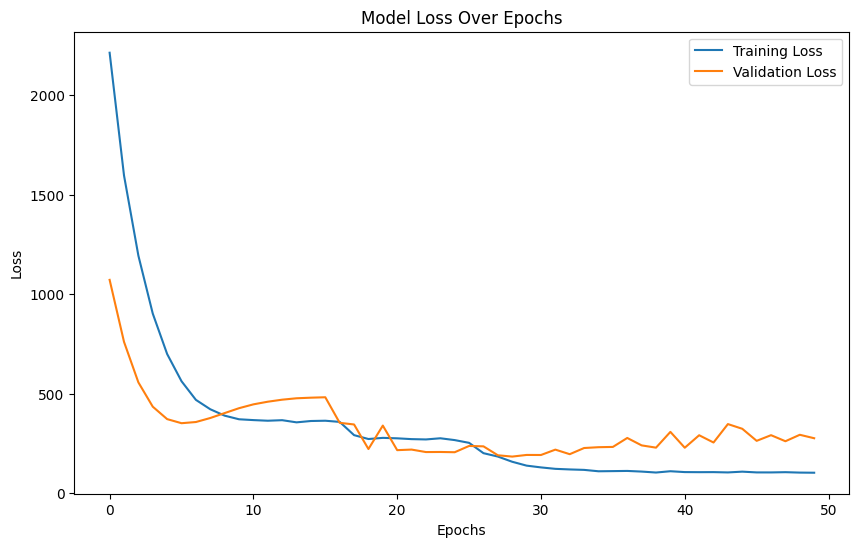

In [10]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
# Generate predictions
y_pred = model.predict(X_test)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r_squared = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')
print(f'R-squared Score: {r_squared:.4f}')

Mean Absolute Error: 13.0471
Root Mean Squared Error: 16.6214
R-squared Score: 0.2135


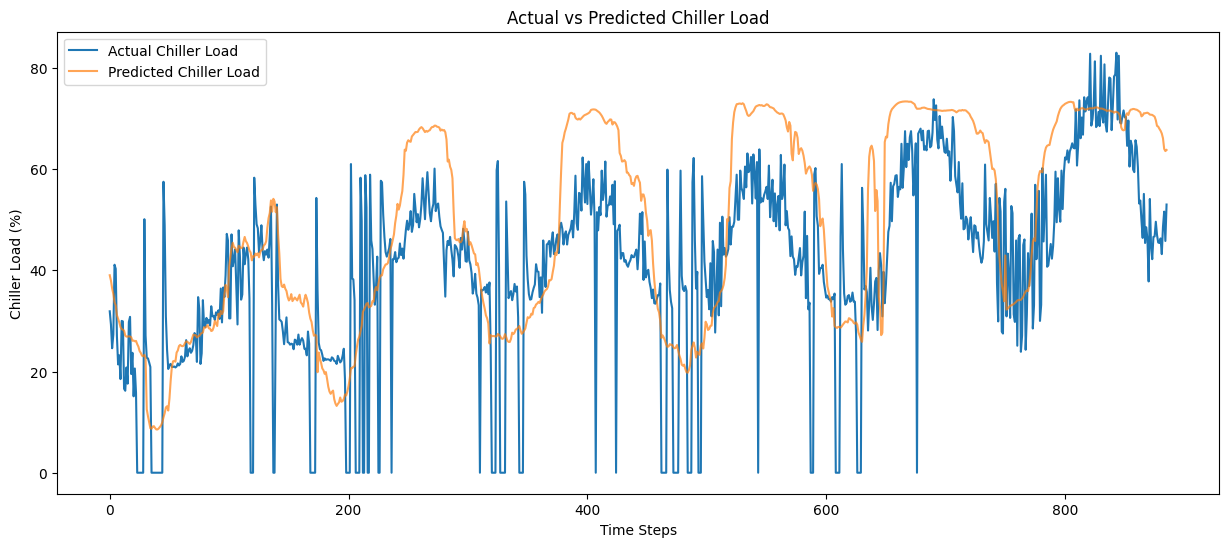

In [13]:
# Plot actual vs predicted values
plt.figure(figsize=(15, 6))
plt.plot(y_test, label='Actual Chiller Load')
plt.plot(y_pred, label='Predicted Chiller Load', alpha=0.7)
plt.title('Actual vs Predicted Chiller Load')
plt.xlabel('Time Steps')
plt.ylabel('Chiller Load (%)')
plt.legend()
plt.show()

In [14]:
mean_actual = np.mean(y_test)
cvrmse = (rmse / mean_actual) * 100
print(f'Coefficient of Variation of RMSE (CVRMSE): {cvrmse:.2f}%')

Coefficient of Variation of RMSE (CVRMSE): 40.77%


In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 128)        │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 394,469 (1.50 MB)

 Trainable params: 131,489 (513.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 262,980 (1.00 MB)

In [16]:
model.save('23_12_model_LSTM.keras')